In [6]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(0, os.path.abspath('../src'))
from shallowwater import (ModelParams, make_grid, setup_initial_state,
                          coastal_alongshore_wind_forcing, run_model, compute_dt_cfl)
import numpy as np
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# --- Alongshore wind band near an east coast → coastal setup → Kelvin wave release ---

# Basin & grid
Nx, Ny = 160, 120
Lx, Ly = 2.0e6, 1.5e6
grid = make_grid(Nx, Ny, Lx, Ly)

# f-plane is fine for coastal Kelvin; mild friction to damp high-frequency noise
params = ModelParams(H=100.0, g=9.81, rho=1025.0,
                     f0=1.0e-4, beta=0.0, y0=Ly/2,
                     r=1/(5*86400), linear=True)

dt = compute_dt_cfl(grid, params, cfl=0.5)
tmax = 72 * 3600.0  # 3 days

# Start from rest
ic_fn = lambda g, p: setup_initial_state(g, p, mode="rest")

# East-coast, northward wind (NH) → Ekman to the right (= onshore) → setup
# Ramp 6 h, hold until 18 h, then shut off → free coastal Kelvin wave propagates *northward*
forcing_fn = lambda t, g, p: coastal_alongshore_wind_forcing(
    t, g, p,
    coast="east",
    direction="north",
    tau0=0.15,          # ~0.15 N/m^2
    Lw=8.0e4,           # ~80 km wind band
    t_ramp=6*3600,
    t_off=18*3600       # set None to keep wind steady
)

# Save frequently to see the adjustment and the wave
out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=12, out_vars=("eta","u","v"))

print("Saved steps:", len(out["time"]))


Saved steps: 109


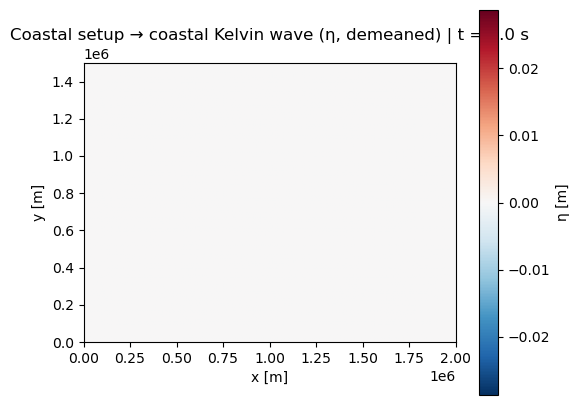

In [12]:
from shallowwater.visualize import animate_eta, coast_hovmoller, plot_forcings

# Demeaned red/blue with contours – watch setup build, then the Kelvin pulse ride poleward
anim = animate_eta(out, grid, interval=100, contours=True, contour_levels=21,
                   title="Coastal setup → coastal Kelvin wave (η, demeaned)")

# GIF (no external dependencies)
anim.save("eta_09.gif", fps=10)

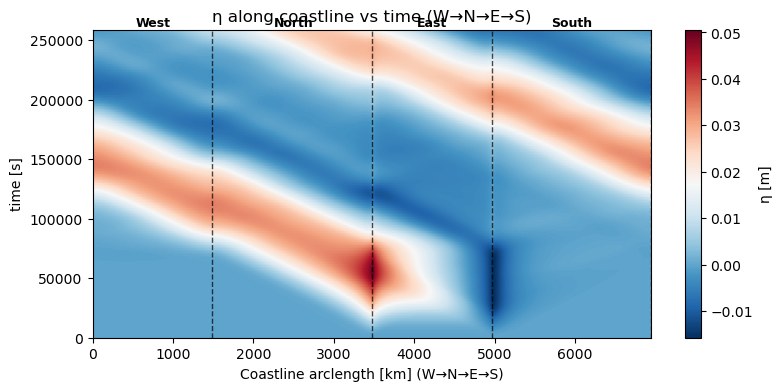

In [13]:
# Hovmöller along coastline to see poleward propagation clearly
figH = coast_hovmoller(out, grid, units_x="km",
                       title="η along coastline vs time (W→N→E→S)")

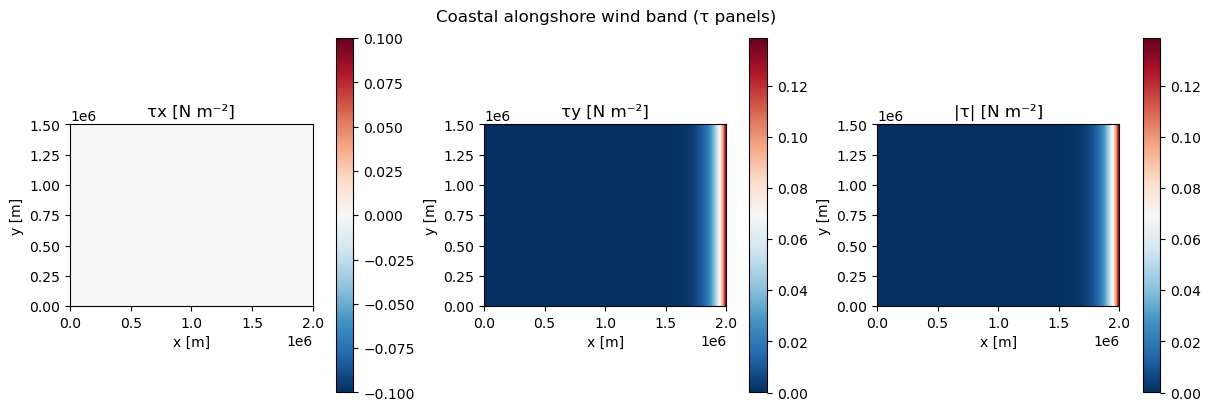

In [14]:
# Forcings (τx, τy, |τ|) at mid-forcing time
t_mid = 12*3600.0
figF = plot_forcings(lambda tt, g, p: coastal_alongshore_wind_forcing(tt, g, p),
                     t_mid, grid, params, what="wind",
                     title="Coastal alongshore wind band (τ panels)")